# Romanized Nepali Text Classification

## Environment Setup and Configuration

### Import Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc
)

# Text preprocessing
import re
from collections import Counter

# Utilities
import warnings
import os
from pathlib import Path

# Suppress warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


### Set Random Seeds for Reproducibility

In [2]:
# Setting random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"Random seed set to: {RANDOM_STATE}")

Random seed set to: 42


### Configure Visualization Settings

In [3]:
# Set matplotlib and seaborn styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure default figure size
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Color palette for sentiment classes
COLORS = {
    -1: '#e74c3c',  # Red for negative
    0: '#95a5a6',   # Gray for neutral
    1: '#2ecc71'    # Green for positive
}

print("Visualization settings configured!")

Visualization settings configured!


### Define Project Constants

In [4]:
# File paths
DATA_PATH = 'data/romanized_nepali_dataset.csv'
FIGURES_DIR = 'figures/'

# Model parameters
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2
CV_FOLDS = 5

# Label mapping
LABEL_MAPPING = {
    -1: 'Negative',
    0: 'Neutral',
    1: 'Positive'
}

print("Project constants defined!")

#creating the figures directory if it doesn't exist
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)
    print(f"Created directory: {FIGURES_DIR}")

Project constants defined!


## Data Loading and Initial Exploration

### Load Dataset

In [5]:
# Load the dataset
df = pd.read_csv(DATA_PATH)

print(f"Dataset loaded successfully from: {DATA_PATH}")
print(f"Total records: {len(df)}")

Dataset loaded successfully from: data/romanized_nepali_dataset.csv
Total records: 1792


### Dataset Information

In [6]:
# Display basic dataset information
print("DATASET INFORMATION")
print(f"\nShape: {df.shape}")
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")
print(f"\nColumn Names: {list(df.columns)}")
print(f"\nData Types:\n{df.dtypes}")

print(f"\nMemory Usage:\n{df.memory_usage(deep=True)}")


DATASET INFORMATION

Shape: (1792, 2)
Rows: 1792
Columns: 2

Column Names: ['sentence', 'label']

Data Types:
sentence    object
label        int64
dtype: object

Memory Usage:
Index          128
sentence    379784
label        14336
dtype: int64


### Preview Dataset

In [7]:
# Display last few rows
print("Last 10 rows of the dataset:")
df.tail(10)

Last 10 rows of the dataset:


,sentence,label
1782,Government transparency ko lagi e governance R...,0
1783,Political reforms ma electoral system party fi...,0
1784,Constitution amendment ko process parliament a...,-1
1785,Federal system le local representation ra effe...,0
1786,Constitution le freedom equality education hea...,0
1787,Federal budget allocation population geography...,1
1788,Constitution Nepal ko democracy ko backbone ho...,0
1789,Public participation consultations feedback ra...,-1
1790,Constitution law ko framework ho ani aru laws ...,0
1791,Constitutional rights protection judiciary ra ...,-1


### Check for Missing Values

In [8]:
# Check for missing values
print("MISSING VALUES ANALYSIS")
print(f"\nTotal missing values per column:")
print(df.isnull().sum())
print(f"\nPercentage of missing values:")
print((df.isnull().sum() / len(df)) * 100)
print(f"\nTotal missing values in dataset: {df.isnull().sum().sum()}")


MISSING VALUES ANALYSIS

Total missing values per column:
sentence    0
label       0
dtype: int64

Percentage of missing values:
sentence    0.0
label       0.0
dtype: float64

Total missing values in dataset: 0


### Statistical Summary

In [9]:
# Statistical summary
print("Statistical Summary:")
df.describe(include='all')

Statistical Summary:


,sentence,label
count,1792,1792.000000
unique,1792,NaN
top,Local election ma vote halna voter list pollin...,NaN
freq,1,NaN
mean,NaN,0.178571
std,NaN,0.523516
min,NaN,-1.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


### Class Distribution - Pie Plot

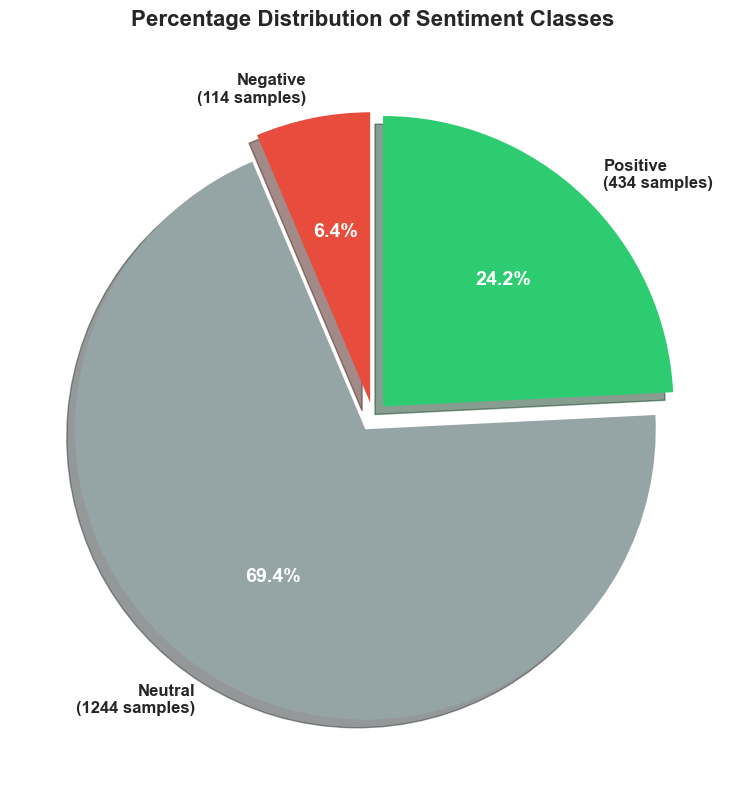

In [10]:
# Pie chart with percentage distribution
fig, ax = plt.subplots(figsize=(10, 8))

class_counts = df['label'].value_counts().sort_index()
labels_with_counts = [f"{LABEL_MAPPING[label]}\n({count} samples)" 
                      for label, count in zip(class_counts.index, class_counts.values)]
colors_list = [COLORS[label] for label in class_counts.index]

wedges, texts, autotexts = ax.pie(class_counts.values, 
                                    labels=labels_with_counts,
                                    colors=colors_list,
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    explode=[0.05] * len(class_counts),
                                    shadow=True,
                                    textprops={'fontsize': 12, 'fontweight': 'bold'})

# Enhance autotext
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

ax.set_title('Percentage Distribution of Sentiment Classes', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}class_distribution_pie.png', dpi=300, bbox_inches='tight')
plt.show()



### Sample Texts from Each Category

In [11]:
# Display sample texts from each category
print("SAMPLE TEXTS FROM EACH CATEGORY")

for label in sorted(df['label'].unique()):
    print(f"\n{LABEL_MAPPING[label].upper()} (Label: {label})")
    print("-"*100)
    samples = df[df['label'] == label]['sentence'].head(5)
    for idx, text in enumerate(samples, 1):
        print(f"{idx}. {text}")
    print()



SAMPLE TEXTS FROM EACH CATEGORY

NEGATIVE (Label: -1)
----------------------------------------------------------------------------------------------------
1. aru thik xa size sano vo ani damage raxa thau thau ma febical le taleko
2. khari ni jhardai xa
3. i ordered orange but this is what i got
4. delivery time so long
5. yo saman bigreko parecha aba kehi garna milcha ki


NEUTRAL (Label: 0)
----------------------------------------------------------------------------------------------------
1. Ma movie pachi sad hunchu.
2. Constitution of Nepal ko publication date ra 2020 samma ko amendments ko number kati chha?
3. Constitution ko preamble le Nepal ko core values, sovereignty, ra national identity lai kasto reflect garchha, tyo kura bujhnuparne ho.
4. Constitution of Nepal ma k ho recognized national symbols ra languages?
5. Constitution ma citizenship ra nationality ko rights ra provisions k ho?


POSITIVE (Label: 1)
--------------------------------------------------------------------

## Exploratory Data Analysis (EDA)

### Import Plotly for Interactive Visualizations

In [12]:
# Import Plotly libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Plotly libraries imported successfully!")

Plotly libraries imported successfully!


### Text Feature Engineering

In [13]:
# Calculate text statistics
df['char_count'] = df['sentence'].apply(len)
df['word_count'] = df['sentence'].apply(lambda x: len(str(x).split()))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['sentence_lower'] = df['sentence'].str.lower()

print("Text features calculated!")
print("\nFeature Summary:")
print("="*60)
print(f"Average character count: {df['char_count'].mean():.2f}")
print(f"Average word count: {df['word_count'].mean():.2f}")
print(f"Average word length: {df['avg_word_length'].mean():.2f}")
print("="*60)

Text features calculated!

Feature Summary:
Average character count: 154.93
Average word count: 24.07
Average word length: 6.30


### Vocabulary Analysis

In [14]:
# Calculate vocabulary statistics
all_words = ' '.join(df['sentence_lower']).split()
unique_words = set(all_words)
vocabulary_size = len(unique_words)

# Word frequency
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)

print("="*60)
print("VOCABULARY ANALYSIS")
print("="*60)
print(f"Total words: {len(all_words)}")
print(f"Unique words: {vocabulary_size}")
print(f"Vocabulary richness: {vocabulary_size / len(all_words) * 100:.2f}%")
print("\nTop 20 Most Frequent Words:")
print("-"*60)
for word, freq in most_common_words:
    print(f"{word:20} : {freq:4} occurrences")
print("="*60)

VOCABULARY ANALYSIS
Total words: 43139
Unique words: 6171
Vocabulary richness: 14.30%

Top 20 Most Frequent Words:
------------------------------------------------------------
ko                   : 2414 occurrences
ma                   : 1489 occurrences
ra                   : 1177 occurrences
garna                :  715 occurrences
le                   :  690 occurrences
lai                  :  639 occurrences
tapai                :  635 occurrences
lagi                 :  561 occurrences
pani                 :  461 occurrences
haru                 :  440 occurrences
ekdum                :  344 occurrences
ani                  :  323 occurrences
hamro                :  252 occurrences
kasto                :  246 occurrences
yo                   :  220 occurrences
ki                   :  207 occurrences
k                    :  204 occurrences
nepal                :  200 occurrences
garnu                :  196 occurrences
chha.                :  196 occurrences


### Check for Duplicate Entries

In [15]:
# Check for duplicates
duplicates = df.duplicated(subset=['sentence']).sum()
duplicate_rows = df[df.duplicated(subset=['sentence'], keep=False)].sort_values('sentence')

print("="*60)
print("DUPLICATE ANALYSIS")
print("="*60)
print(f"Total duplicate sentences: {duplicates}")
print(f"Percentage of duplicates: {duplicates / len(df) * 100:.2f}%")

if duplicates > 0:
    print("\nSample duplicate entries:")
    print("-"*60)
    print(duplicate_rows.head(10))
else:
    print("\nNo duplicate entries found!")
print("="*60)

DUPLICATE ANALYSIS
Total duplicate sentences: 0
Percentage of duplicates: 0.00%

No duplicate entries found!


## Data Preprocessing and Train-Test Split

In [16]:
# Split the data into features (X) and target (y)
X = df['sentence']
y = df['label']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set size: 1433
Testing set size: 359

Class distribution in training set:
label
 0    0.694348
 1    0.242149
-1    0.063503
Name: proportion, dtype: float64


### Feature Extraction: TF-IDF (for Classical Models)

In [17]:
# Initialize TV-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Include unigrams and bigrams
    min_df=2,            # Ignore terms that appear in less than 2 documents
    max_df=0.95          # Ignore terms that appear in more than 95% of documents
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF Matrix Shape (Train): {X_train_tfidf.shape}")
print(f"TF-IDF Matrix Shape (Test): {X_test_tfidf.shape}")

TF-IDF Matrix Shape (Train): (1433, 5000)
TF-IDF Matrix Shape (Test): (359, 5000)


## Model Training and Evaluation

In [18]:
# Dictionary to store results from all models for final comparison
all_model_results = {}

# Map numeric labels to names if needed, or use directly
target_names = ['Negative', 'Neutral', 'Positive'] # Assuming -1, 0, 1 mapping

### 1. Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)
y_prob_lr = lr_model.predict_proba(X_test_tfidf)

# Store results
all_model_results['Logistic Regression'] = {
    'predicted': y_pred_lr,
    'probabilities': y_prob_lr,
    'report': classification_report(y_test, y_pred_lr, output_dict=True)
}

print(classification_report(y_test, y_pred_lr))

Training Logistic Regression...
              precision    recall  f1-score   support

          -1       0.15      0.17      0.16        23
           0       0.94      0.88      0.91       249
           1       0.70      0.79      0.74        87

    accuracy                           0.81       359
   macro avg       0.60      0.62      0.60       359
weighted avg       0.83      0.81      0.82       359



### 2. Support Vector Machine (SVM)

In [20]:
from sklearn.svm import SVC

print("Training Support Vector Machine...")
# probability=True is required for ROC curves, though it slows down training
svm_model = SVC(kernel='linear', probability=True, random_state=RANDOM_STATE, class_weight='balanced')
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_tfidf)
y_prob_svm = svm_model.predict_proba(X_test_tfidf)

# Store results
all_model_results['SVM'] = {
    'predicted': y_pred_svm,
    'probabilities': y_prob_svm,
    'report': classification_report(y_test, y_pred_svm, output_dict=True)
}

print(classification_report(y_test, y_pred_svm))

Training Support Vector Machine...
              precision    recall  f1-score   support

          -1       0.11      0.09      0.10        23
           0       0.94      0.88      0.91       249
           1       0.67      0.83      0.74        87

    accuracy                           0.82       359
   macro avg       0.57      0.60      0.58       359
weighted avg       0.82      0.82      0.82       359



### 3. Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced')
rf_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_tfidf)
y_prob_rf = rf_model.predict_proba(X_test_tfidf)

# Store results
all_model_results['Random Forest'] = {
    'predicted': y_pred_rf,
    'probabilities': y_prob_rf,
    'report': classification_report(y_test, y_pred_rf, output_dict=True)
}

print(classification_report(y_test, y_pred_rf))

Training Random Forest...
              precision    recall  f1-score   support

          -1       0.50      0.04      0.08        23
           0       0.90      0.90      0.90       249
           1       0.66      0.84      0.74        87

    accuracy                           0.83       359
   macro avg       0.69      0.59      0.57       359
weighted avg       0.82      0.83      0.81       359



### 4. Multilingual BERT (mBERT)

In [22]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Initialize Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# 2. Prepare Data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        # The label in dataset is -1, 0, 1. Transformers need 0, 1, 2.
        # We add 1 to label to make it 0, 1, 2
        label = self.labels[item] + 1 

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Reset index to ensure alignment
X_train_list = X_train.reset_index(drop=True)
y_train_list = y_train.reset_index(drop=True)
X_test_list = X_test.reset_index(drop=True)
y_test_list = y_test.reset_index(drop=True)

train_dataset = TextDataset(X_train_list, y_train_list, tokenizer)
test_dataset = TextDataset(X_test_list, y_test_list, tokenizer)

# 3. Initialize Model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)
model.to(device)

# 4. Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=7,                 # setring the epoch to the best epoch from experiment done through hyperparamter tuning
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",              
    load_best_model_at_end=True,        
    metric_for_best_model="f1",          
    greater_is_better=True,
    report_to="none"
)

# 5. Define Metrics Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 6. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# 7. Train
print("Training mBERT...")
trainer.train()

# 8. Evaluate and Store Results
predictions = trainer.predict(test_dataset)
y_pred_mbert = predictions.predictions.argmax(-1)
# Convert back to -1, 0, 1 from 0, 1, 2
y_pred_mbert_original = y_pred_mbert - 1
# Softmax to get probabilities
y_prob_mbert = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()

all_model_results['mBERT'] = {
    'predicted': y_pred_mbert_original,
    'probabilities': y_prob_mbert,
    'report': classification_report(y_test, y_pred_mbert_original, output_dict=True)
}

print(classification_report(y_test, y_pred_mbert_original))

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training mBERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.324500,0.478333,0.835655,0.819921,0.835756,0.835655
2,0.283300,0.405921,0.830084,0.815118,0.833747,0.830084
3,0.356100,0.428451,0.818942,0.805505,0.829885,0.818942
4,0.306700,0.459588,0.813370,0.800057,0.825600,0.813370
5,0.271700,0.435799,0.807799,0.796534,0.828744,0.807799
6,0.422300,0.403567,0.830084,0.815731,0.836050,0.830084
7,0.488800,0.408865,0.838440,0.821740,0.834609,0.838440


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        23
           0       0.99      0.86      0.92       249
           1       0.61      1.00      0.76        87

    accuracy                           0.84       359
   macro avg       0.53      0.62      0.56       359
weighted avg       0.83      0.84      0.82       359



## Model Comparison and Visualization

Model Comparison Summary:


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.813370,0.827892,0.813370,0.819233
1,SVM,0.816156,0.819321,0.816156,0.815104
2,Random Forest,0.827298,0.819059,0.827298,0.808402
3,mBERT,0.838440,0.834609,0.838440,0.821740


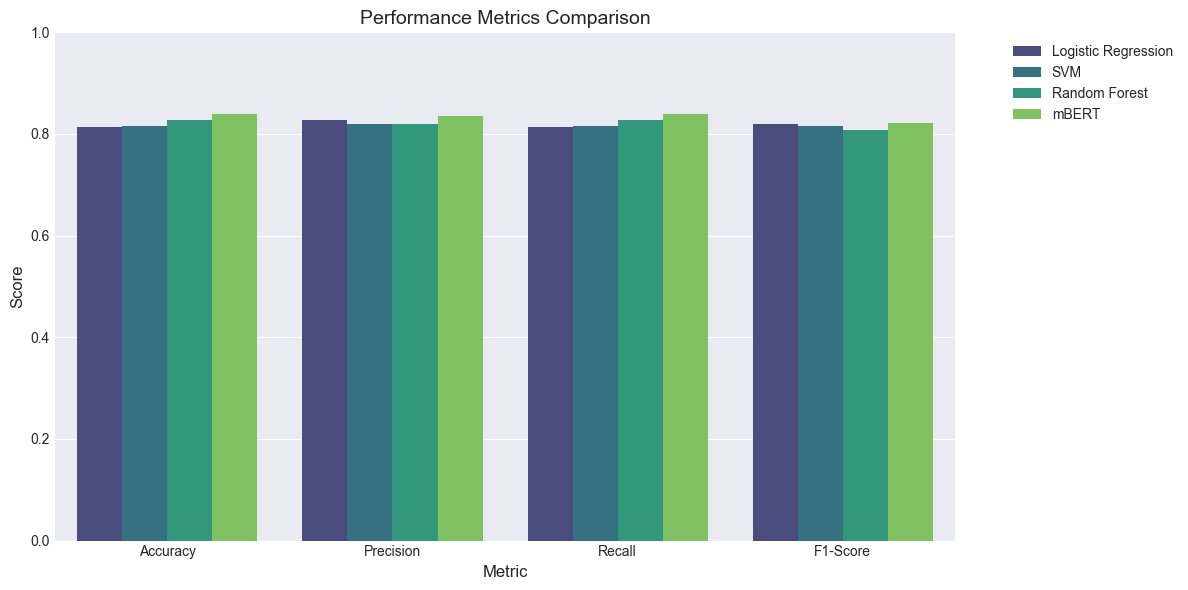

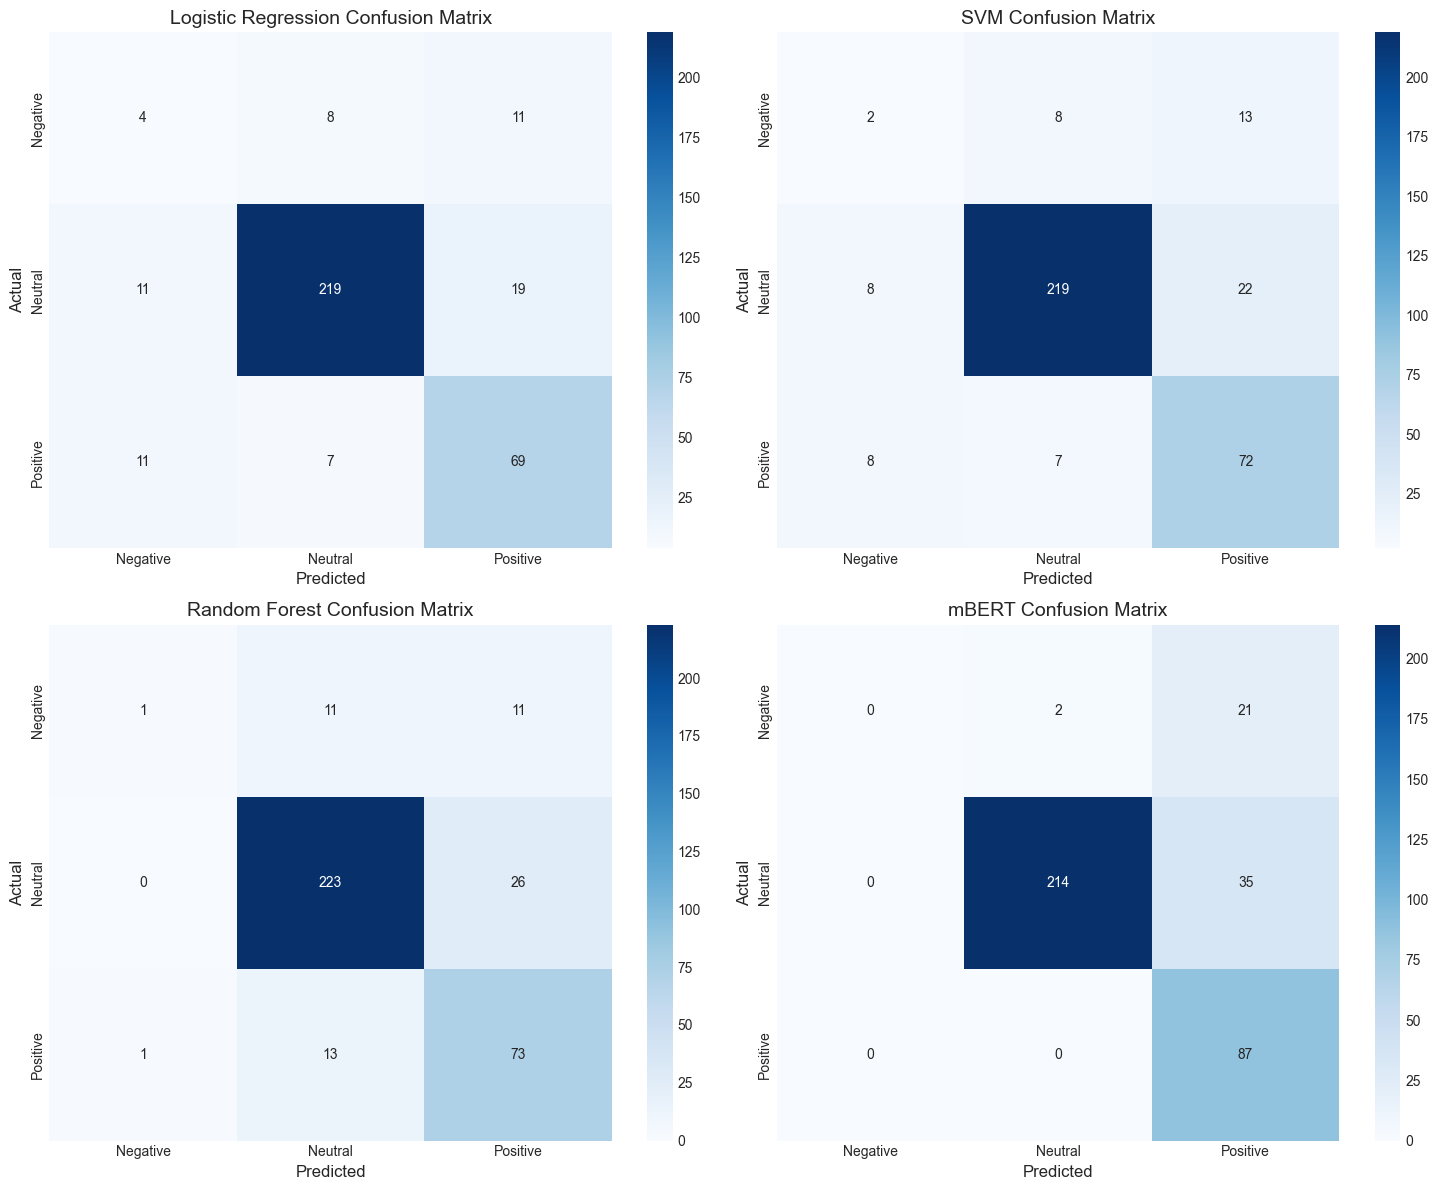

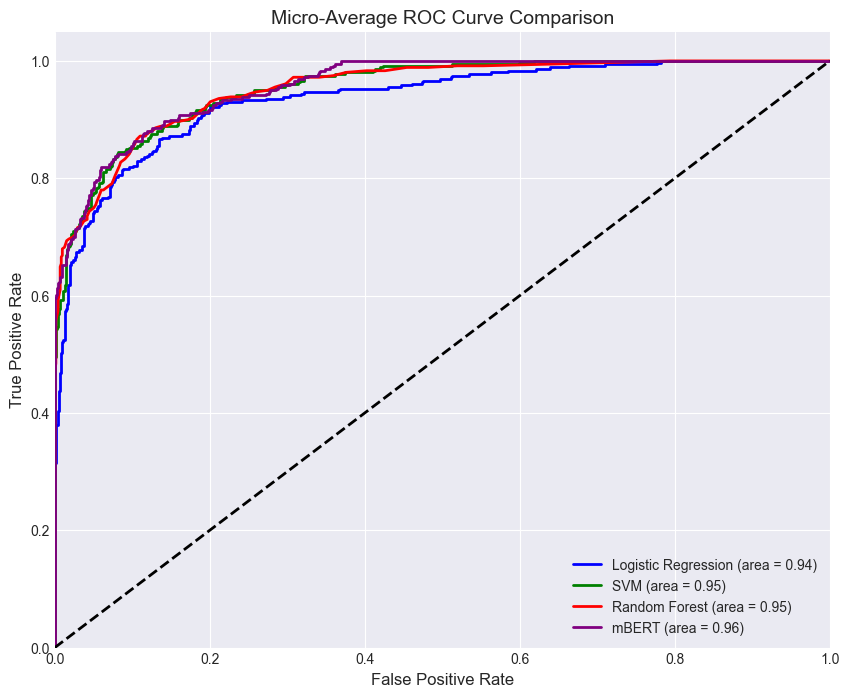

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Metrics Comparison Table
metrics_list = []
for model_name, res in all_model_results.items():
    rep = res['report']
    metrics_list.append({
        'Model': model_name,
        'Accuracy': rep['accuracy'],
        'Precision': rep['weighted avg']['precision'],
        'Recall': rep['weighted avg']['recall'],
        'F1-Score': rep['weighted avg']['f1-score']
    })

comparison_df = pd.DataFrame(metrics_list)
print("Model Comparison Summary:")
display(comparison_df)

# 2. Bar Chart of Metrics
plt.figure(figsize=(12, 6))
melted_df = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(x='Metric', y='Score', hue='Model', data=melted_df, palette='viridis')
plt.title('Performance Metrics Comparison')
plt.ylim(0, 1.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (model_name, res) in enumerate(all_model_results.items()):
    cm = confusion_matrix(y_test, res['predicted'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    axes[idx].set_title(f'{model_name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    
plt.tight_layout()
plt.show()

# 4. ROC Curves (Multiclass)
# Binarize labels for ROC
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'purple']
for (model_name, res), color in zip(all_model_results.items(), colors):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_score = res['probabilities']
    
    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'{model_name} (area = {roc_auc["micro"]:.2f})',
             color=color, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

## Models in Action

### Saving the model weights

In [24]:
# savig the models
import joblib
from transformers import BertTokenizer, BertForSequenceClassification
import os
import torch

# Create directory if it doesn't exist
model_dir = 'models_store'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Created directory: {model_dir}")

# Save sklearn models and vectorizer
print("Saving sklearn models...")
try:
    if 'lr_model' in globals(): joblib.dump(lr_model, os.path.join(model_dir, 'lr_model.joblib'))
    if 'svm_model' in globals(): joblib.dump(svm_model, os.path.join(model_dir, 'svm_model.joblib'))
    if 'rf_model' in globals(): joblib.dump(rf_model, os.path.join(model_dir, 'rf_model.joblib'))
    if 'tfidf_vectorizer' in globals(): joblib.dump(tfidf_vectorizer, os.path.join(model_dir, 'tfidf_vectorizer.joblib'))
    print("Sklearn models saved.")
except Exception as e:
    print(f"Error saving sklearn models: {e}")

# Save mBERT model
print("Saving mBERT model...")
try:
    if 'model' in globals() and 'tokenizer' in globals():
        model.save_pretrained(os.path.join(model_dir, 'mbert_model'))
        tokenizer.save_pretrained(os.path.join(model_dir, 'mbert_model'))
        print("mBERT model saved.")
except Exception as e:
    print(f"Error saving mBERT model: {e}")

Created directory: models_store
Saving sklearn models...
Sklearn models saved.
Saving mBERT model...
mBERT model saved.


### loading the model weights

In [25]:
# loading the models for inference
print("\nLoading models for inference...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_models = {}

try:
    loaded_models['lr'] = joblib.load(os.path.join(model_dir, 'lr_model.joblib'))
    loaded_models['svm'] = joblib.load(os.path.join(model_dir, 'svm_model.joblib'))
    loaded_models['rf'] = joblib.load(os.path.join(model_dir, 'rf_model.joblib'))
    loaded_models['tfidf'] = joblib.load(os.path.join(model_dir, 'tfidf_vectorizer.joblib'))
    print("Sklearn models loaded.")
except Exception as e:
    print(f"Error loading sklearn models: {e}")

try:
    mbert_path = os.path.join(model_dir, 'mbert_model')
    loaded_models['tokenizer'] = BertTokenizer.from_pretrained(mbert_path)
    loaded_models['mbert'] = BertForSequenceClassification.from_pretrained(mbert_path)
    loaded_models['mbert'].to(device)
    print("mBERT model loaded.")
except Exception as e:
    print(f"Error loading mBERT model: {e}")


Loading models for inference...
Sklearn models loaded.
mBERT model loaded.


### running the inference

In [26]:
# running the inference
def predict_sentiment(text):
    print(f"\nInference on text: '{text}'\n" + "-"*50)
    
    # Ensure mapping exists
    LOCAL_LABEL_MAPPING = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
    
    # Classical Models Inference
    if 'tfidf' in loaded_models:
        try:
            text_tfidf = loaded_models['tfidf'].transform([text])
            if 'lr' in loaded_models:
                pred = loaded_models['lr'].predict(text_tfidf)[0]
                print(f"{'Logistic Regression':20}: {LOCAL_LABEL_MAPPING.get(pred, pred)}")
            if 'svm' in loaded_models:
                pred = loaded_models['svm'].predict(text_tfidf)[0]
                print(f"{'SVM':20}: {LOCAL_LABEL_MAPPING.get(pred, pred)}")
            if 'rf' in loaded_models:
                pred = loaded_models['rf'].predict(text_tfidf)[0]
                print(f"{'Random Forest':20}: {LOCAL_LABEL_MAPPING.get(pred, pred)}")
        except Exception as e:
            print(f"Error in classical inference: {e}")

    # mBERT Inference
    if 'mbert' in loaded_models and 'tokenizer' in loaded_models:
        try:
            inputs = loaded_models['tokenizer'](text, return_tensors="pt", truncation=True, padding=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = loaded_models['mbert'](**inputs)
            # Assuming training mapped -1->0, 0->1, 1->2
            # So prediction 0 is -1, 1 is 0, 2 is 1
            pred_idx = outputs.logits.argmax(dim=-1).item()
            pred_label = pred_idx - 1 
            print(f"{'mBERT':20}: {LOCAL_LABEL_MAPPING.get(pred_label, pred_label)}")
        except Exception as e:
            print(f"Error in mBERT inference: {e}")

# Test with random statements
sample_texts = [
    "Aaja ma dherai khushi chu kinaki maile naya kaam paye.",
    "Yo saman kasto naramro raicha, paisa matra gayo.",
    "Mero naam Satyam ho."
]

for text in sample_texts:
    predict_sentiment(text)


Inference on text: 'Aaja ma dherai khushi chu kinaki maile naya kaam paye.'
--------------------------------------------------
Logistic Regression : Neutral
SVM                 : Positive
Random Forest       : Positive
mBERT               : Neutral

Inference on text: 'Yo saman kasto naramro raicha, paisa matra gayo.'
--------------------------------------------------
Logistic Regression : Neutral
SVM                 : Neutral
Random Forest       : Neutral
mBERT               : Positive

Inference on text: 'Mero naam Satyam ho.'
--------------------------------------------------
Logistic Regression : Neutral
SVM                 : Neutral
Random Forest       : Neutral
mBERT               : Neutral
